In [3]:
import fitransit
from matplotlib import pyplot as plt
import numpy as np
import warnings
from multiprocessing import get_context
import pandas as pd
import os

# 1. Set Target

In [4]:
planet_name = 'WASP-44 b'
planet = fitransit.fitlpf("WASP-44 b")
planet.get_parameter()

WASP-44 b Properties
Stellar Mass 		0.951000 		M_sun
Planet Mass 		0.889836 		M_Jupiter
Planet Orbital Period 	2.423804 		d
Transit Time 		55434.376000 		MJD
Planet Mass Reference: Calculated from MSINI and I


# 2. Download Data (if necessary) from ExoMAST

Default directory is './data/{planet_name}'

In [3]:
planet.download_data()

obs_collection project                      obs_id                    
-------------- ------- -----------------------------------------------
          TESS    TESS tess2018263035959-s0003-0000000012862099-0123-s
                       productFilename                       
-------------------------------------------------------------
tess2018263124740-s0003-s0003-0000000012862099-00405_dvt.fits
tess2018267104341-s0003-s0003-0000000012862099-00126_dvt.fits
      tess2018263035959-s0003-0000000012862099-0123-s_lc.fits
INFO: Found cached file ./data/WASP-44b/mastDownload/TESS/tess2018263035959-s0003-0000000012862099-0123-s/tess2018263124740-s0003-s0003-0000000012862099-00405_dvt.fits with expected size 3968640. [astroquery.query]
INFO: Found cached file ./data/WASP-44b/mastDownload/TESS/tess2018263035959-s0003-0000000012862099-0123-s/tess2018267104341-s0003-s0003-0000000012862099-00126_dvt.fits with expected size 2949120. [astroquery.query]
INFO: Found cached file ./data/WASP-44b/mastDow

Local Path,Status,Message,URL
str143,str8,object,object
./data/WASP-44b/mastDownload/TESS/tess2018263035959-s0003-0000000012862099-0123-s/tess2018263124740-s0003-s0003-0000000012862099-00405_dvt.fits,COMPLETE,None,None
./data/WASP-44b/mastDownload/TESS/tess2018263035959-s0003-0000000012862099-0123-s/tess2018267104341-s0003-s0003-0000000012862099-00126_dvt.fits,COMPLETE,None,None
./data/WASP-44b/mastDownload/TESS/tess2018263035959-s0003-0000000012862099-0123-s/tess2018263035959-s0003-0000000012862099-0123-s_lc.fits,COMPLETE,None,None


# 3. Calculate TTV using MCMC

MCMC sampling: 100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


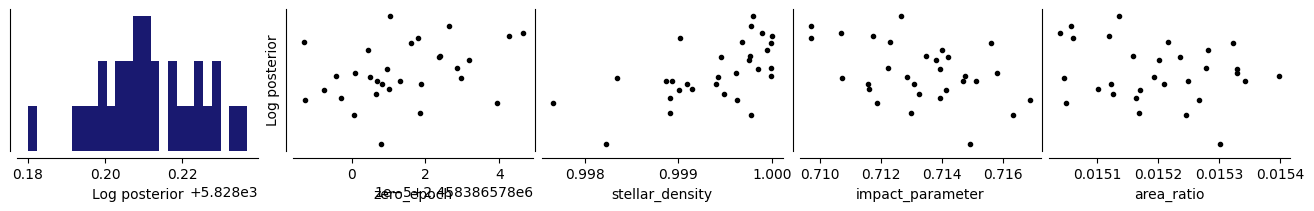

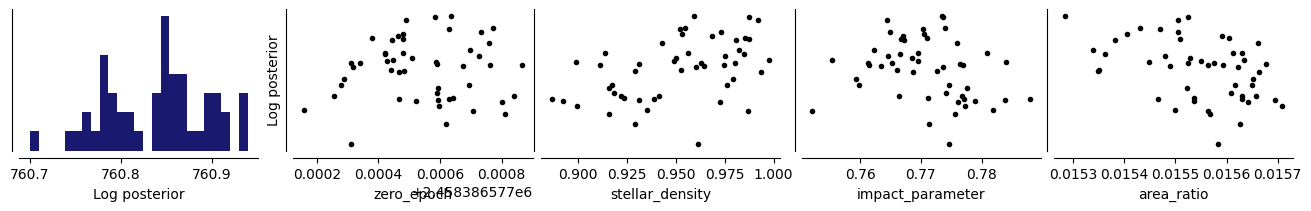

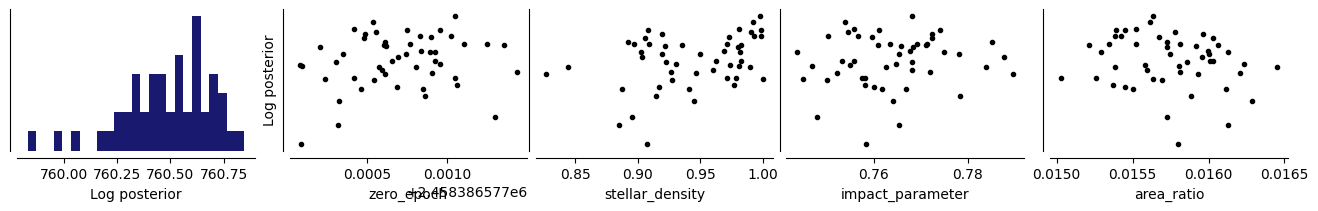

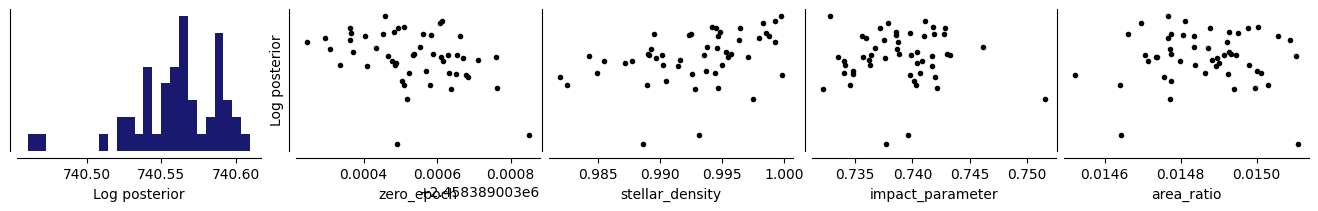

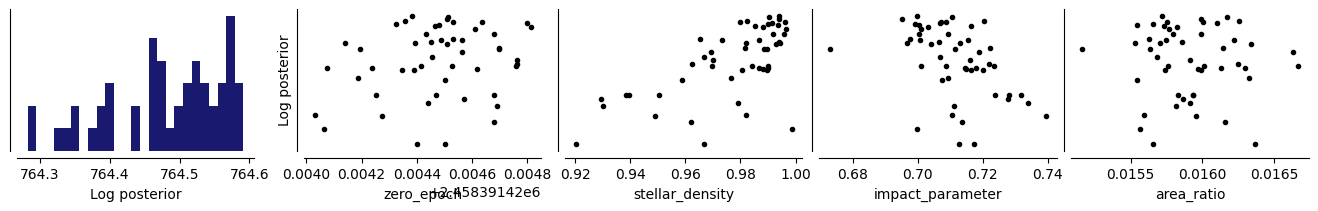

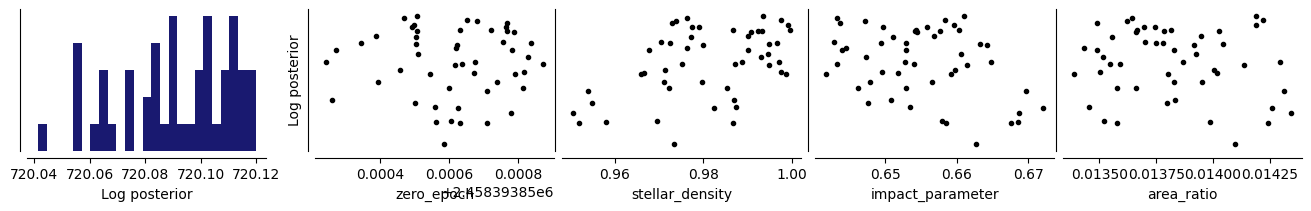

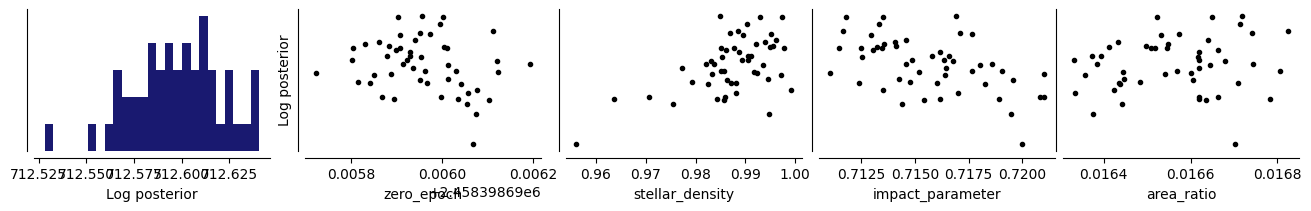

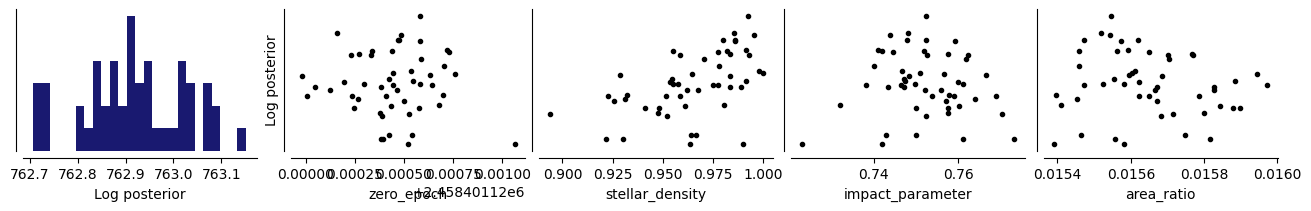

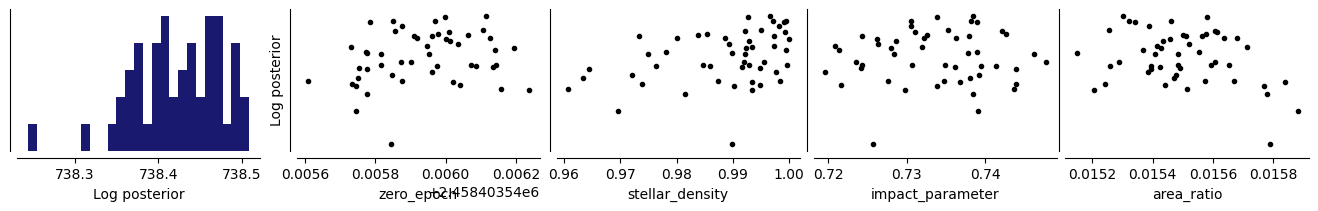

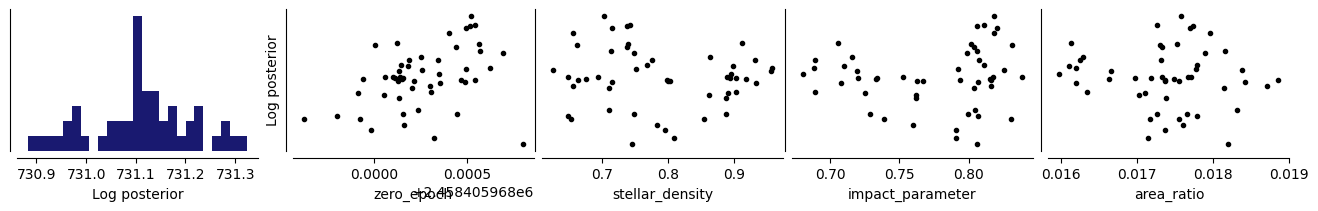

In [5]:
planet.de(datadir = './data/WASP-44b/mastDownload/TESS/tess2018263035959-s0003-0000000012862099-0123-s/')
planet.fit_singles()

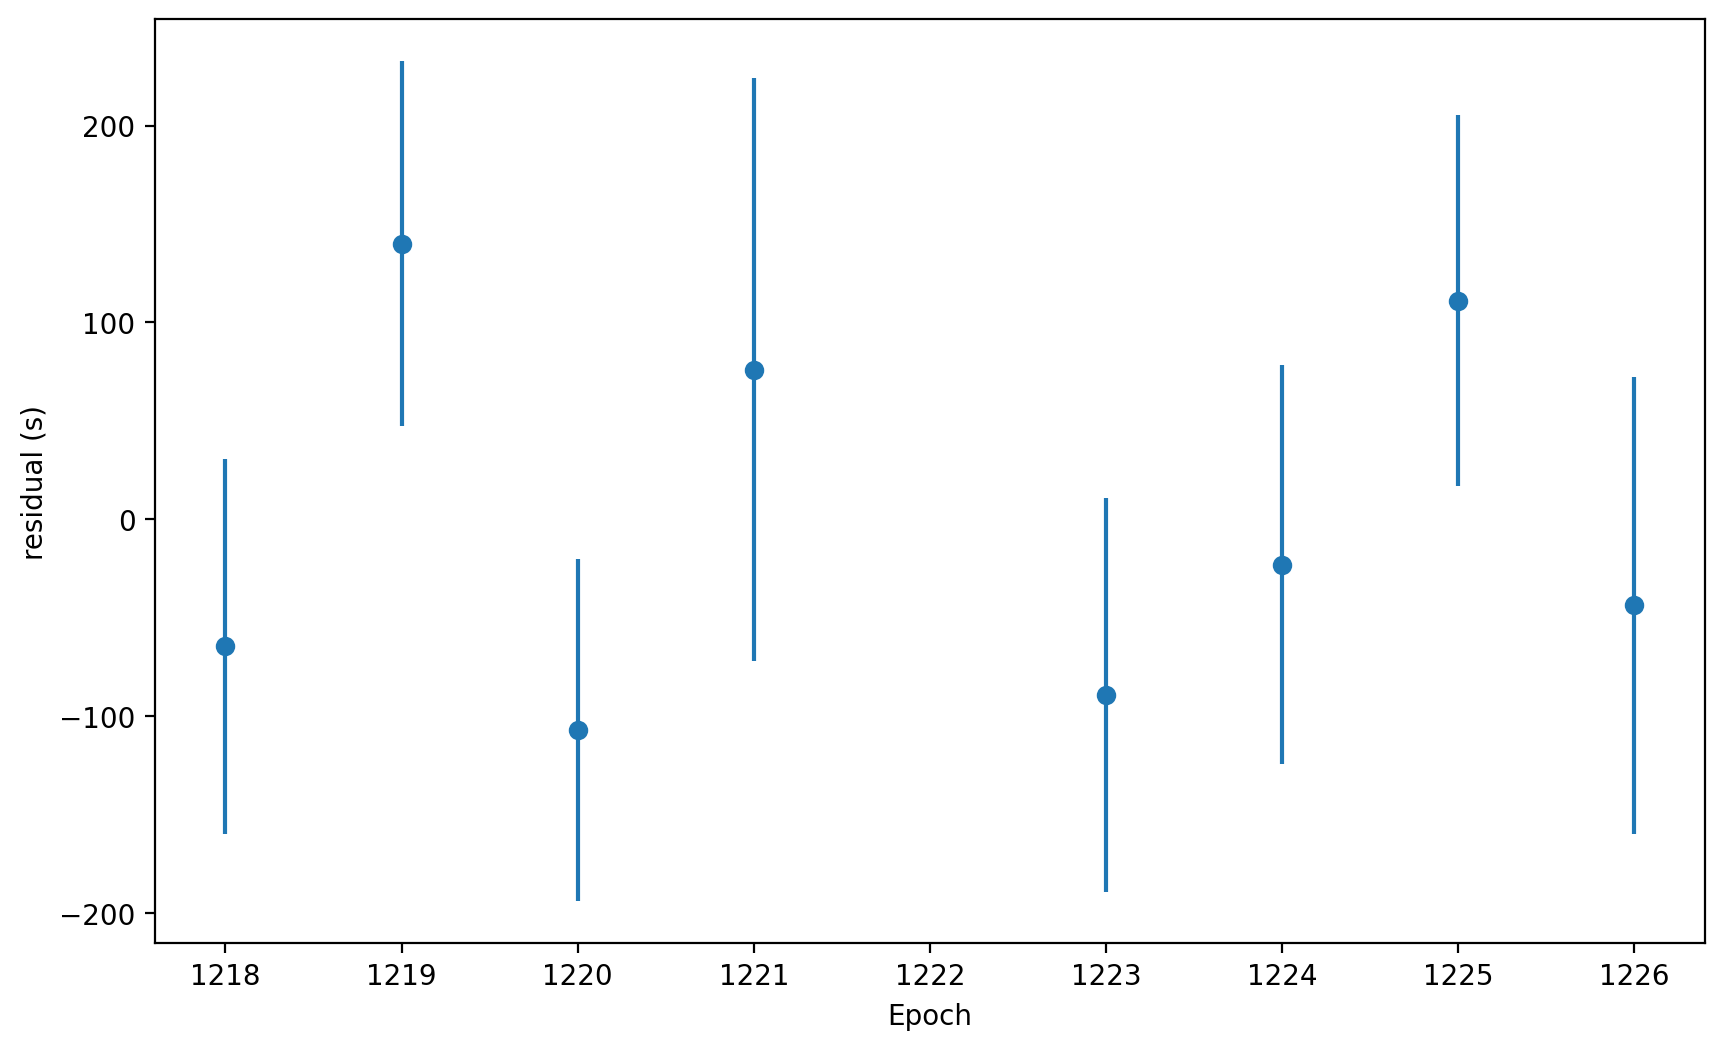

In [6]:
planet.calculate_ttv()
planet.plot_ttv_re()

# 4.Find m_crit

In [7]:
rs = np.linspace(0.1,4,100)
mp2s = np.logspace(-2,5,200)

In [9]:
ttv_sim = fitransit.ttv_sim(epochs=planet.epochs,ttv_mcmc=planet.ttv_mcmc,ttv_err=planet.ttv_err,rs=rs,mp2s=mp2s,prop=planet.prop)

In [10]:
rlt_ttv = ttv_sim.get_ttv_rebound_all(number_of_thread=6)
rlt_chi2, rlt_rms = ttv_sim.get_m_crit()

100%|██████████| 20000/20000 [00:10<00:00, 1849.60it/s]


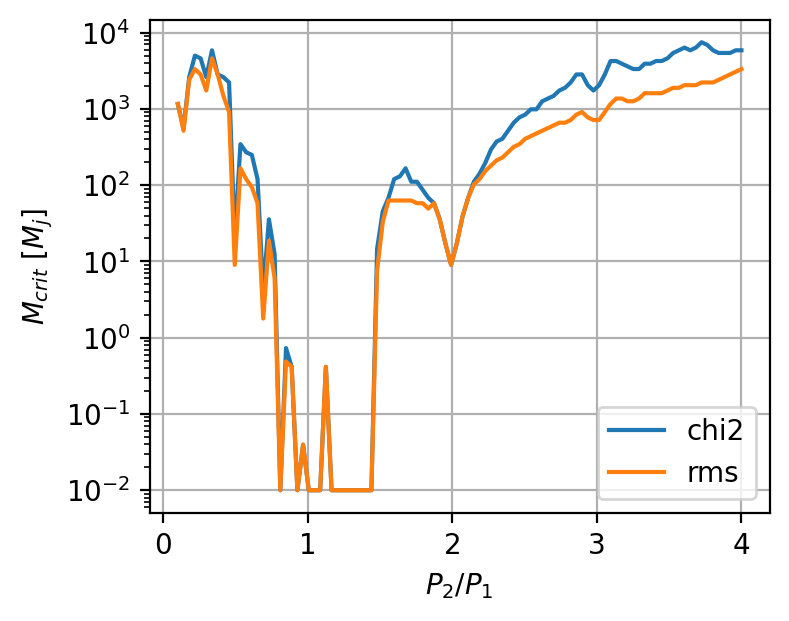

In [11]:
fig,ax = plt.subplots(figsize=(4,3.2),dpi=200)
ax.set_yscale('log')
# ax.set_xscale('log')
plt.grid()
plt.plot(rs,rlt_chi2,label='chi2')
plt.plot(rs,rlt_rms,label='rms')
# plt.vlines(3.3,0,20,linestyle='dashed',color='k')
# new_ticks = [1.5,2,2.5,3,3.3,3.5,4]
# plt.xticks(new_ticks)
plt.xlabel(r"$P_2/P_1$")
plt.ylabel(r"$M_{crit}$ [$M_j$]")
plt.legend()

# 5. Calculate MEGNO

In [12]:
megno_rlt = ttv_sim.run_megno(6)

 93%|█████████▎| 18661/20000 [26:37<01:51, 12.02it/s]/Users/troy/.pyenv/versions/3.10.6/lib/python3.10/site-packages/rebound/simulation.py:1032: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)
100%|██████████| 20000/20000 [28:33<00:00, 11.67it/s]


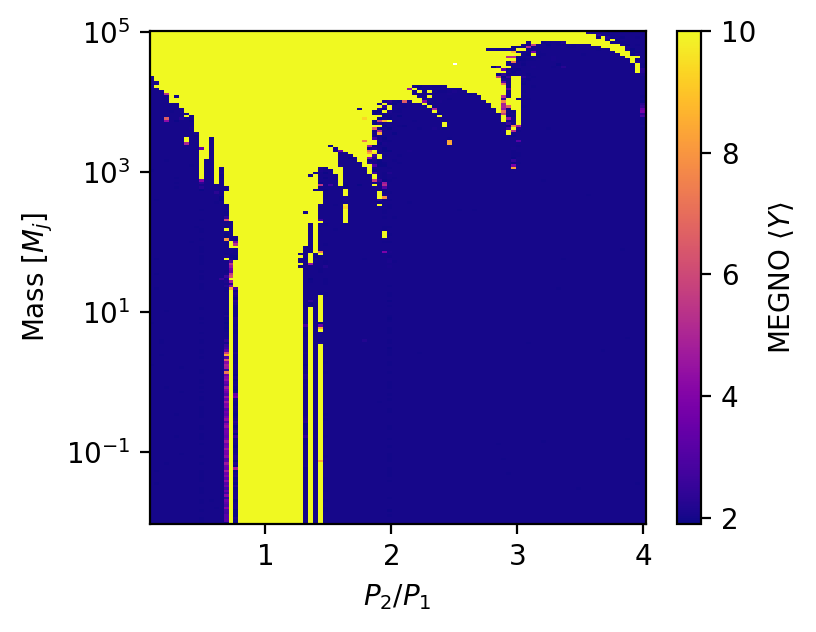

In [13]:
results2d = np.array(megno_rlt).reshape(len(mp2s),len(rs))
fig,ax = plt.subplots(figsize=(4,3.2),dpi=200)
X,Y = np.meshgrid(rs,mp2s)
ax.set_xlabel("$P_2/P_1$")
ax.set_ylabel("Mass [$M_j$]")
# ax.set_xscale('log')
ax.set_yscale('log')
im = ax.pcolor(X,Y,results2d, vmin=1.9, vmax=10, cmap='plasma')
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO $\\langle Y \\rangle$")

# 6. Combined

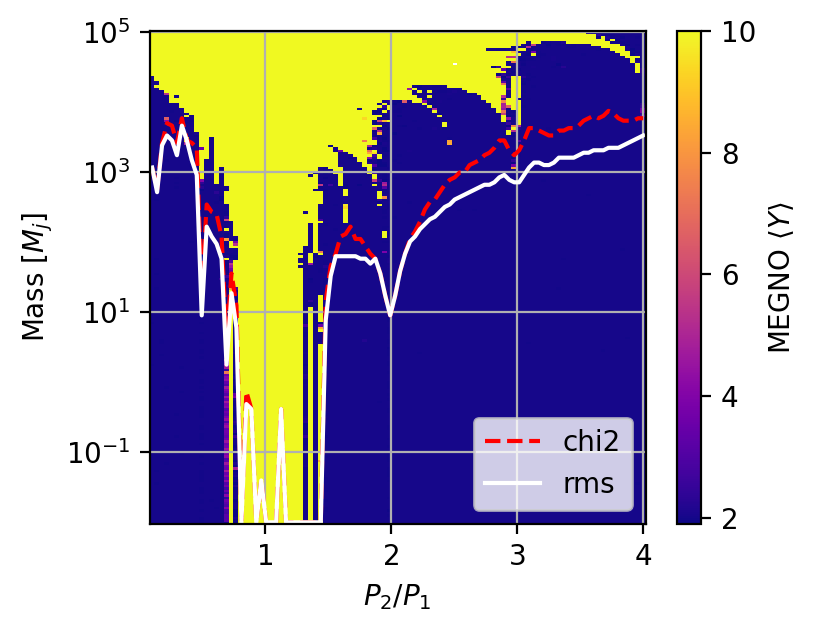

In [14]:
fig,ax = plt.subplots(figsize=(4,3.2),dpi=200)
X,Y = np.meshgrid(rs,mp2s)
ax.set_xlabel("$P_2/P_1$")
ax.set_ylabel("Mass [$M_j$]")
ax.set_yscale('log')
im = ax.pcolor(X,Y,results2d, vmin=1.9, vmax=10, cmap='plasma')
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO $\\langle Y \\rangle$")
plt.grid()
plt.plot(rs,rlt_chi2,'r--',label='chi2')
plt.plot(rs,rlt_rms,'w',label='rms')
plt.legend()
plt.show()